# AFML Part 1 - Team 44_XLR8 (SIMPLE & EFFECTIVE)
## Minimal Preprocessing - Direct Learning

**Strategy**: Less preprocessing, let model learn raw patterns

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✅ Using M2 GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("✅ Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("⚠️  Using CPU")

print(f"Device: {device}")

✅ Using M2 GPU
Device: mps


## Load Data

In [2]:
print("Loading...")
train_clean = pd.read_csv('train-part1-clean.csv').values.astype(np.float32)
train_noise = pd.read_csv('train-part1-noise.csv').values.astype(np.float32)
test_data = pd.read_csv('test-part1.csv').values.astype(np.float32)

print(f"Clean: {train_clean.shape}")
print(f"Noisy: {train_noise.shape}")
print(f"Test: {test_data.shape}")

Loading...
Clean: (1024146, 20)
Noisy: (1024146, 20)
Test: (12732, 20)


## Minimal Preprocessing - NO SCALING!

In [3]:
# Just split - NO SCALING
X_train, X_val, y_train, y_val = train_test_split(
    train_noise, train_clean, test_size=0.15, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# Direct to tensors - NO SCALING
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)
test_t = torch.FloatTensor(test_data)

print("✓ No scaling - direct learning")

Train: (870524, 20), Val: (153622, 20)
✓ No scaling - direct learning


## Simple Deep Network

In [4]:
class SimpleDenoiser(nn.Module):
    def __init__(self, input_dim=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, input_dim)
        )
    
    def forward(self, x):
        return self.net(x)

model = SimpleDenoiser().to(device)
print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

Params: 536,084


## Training

In [5]:
BATCH_SIZE = 2048
NUM_EPOCHS = 100
LR = 0.0005

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=BATCH_SIZE, shuffle=False
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"Batches/epoch: {len(train_loader)}")

Batches/epoch: 425


In [6]:
best_val_loss = float('inf')
train_losses, val_losses = [], []
patience = 0
MAX_PATIENCE = 20

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best.pth')
        patience = 0
        print(f"✓ Epoch {epoch+1} - Train: {train_loss:.6f}, Val: {val_loss:.6f} [SAVED]")
    else:
        patience += 1
        if (epoch+1) % 10 == 0:
            print(f"  Epoch {epoch+1} - Train: {train_loss:.6f}, Val: {val_loss:.6f}")
    
    if patience >= MAX_PATIENCE:
        print(f"Early stop at epoch {epoch+1}")
        break

print(f"\nBest val: {best_val_loss:.6f}")

✓ Epoch 1 - Train: 28.710021, Val: 0.491605 [SAVED]


✓ Epoch 2 - Train: 33.092116, Val: 0.102141 [SAVED]


✓ Epoch 3 - Train: 49.109563, Val: 0.012213 [SAVED]


✓ Epoch 4 - Train: 2.569019, Val: 0.007890 [SAVED]


✓ Epoch 5 - Train: 0.022936, Val: 0.007820 [SAVED]


✓ Epoch 6 - Train: 0.041828, Val: 0.007792 [SAVED]


✓ Epoch 8 - Train: 0.405200, Val: 0.007755 [SAVED]


✓ Epoch 10 - Train: 0.280058, Val: 0.007671 [SAVED]


✓ Epoch 11 - Train: 0.007438, Val: 0.007553 [SAVED]


✓ Epoch 12 - Train: 0.007596, Val: 0.007435 [SAVED]


✓ Epoch 13 - Train: 0.007236, Val: 0.007293 [SAVED]


✓ Epoch 14 - Train: 0.641259, Val: 0.007167 [SAVED]


✓ Epoch 15 - Train: 0.007040, Val: 0.007041 [SAVED]


✓ Epoch 16 - Train: 0.006985, Val: 0.006913 [SAVED]


✓ Epoch 17 - Train: 0.067595, Val: 0.006824 [SAVED]


✓ Epoch 18 - Train: 0.007626, Val: 0.006717 [SAVED]


✓ Epoch 19 - Train: 0.007840, Val: 0.006608 [SAVED]


✓ Epoch 20 - Train: 0.006600, Val: 0.006466 [SAVED]


✓ Epoch 21 - Train: 0.006489, Val: 0.006361 [SAVED]


✓ Epoch 22 - Train: 0.006506, Val: 0.006271 [SAVED]


✓ Epoch 23 - Train: 0.006362, Val: 0.006197 [SAVED]


✓ Epoch 24 - Train: 0.006256, Val: 0.006119 [SAVED]


✓ Epoch 26 - Train: 0.009092, Val: 0.006093 [SAVED]


✓ Epoch 27 - Train: 0.006140, Val: 0.006031 [SAVED]


✓ Epoch 28 - Train: 0.006230, Val: 0.005985 [SAVED]


✓ Epoch 29 - Train: 0.006105, Val: 0.005927 [SAVED]


✓ Epoch 30 - Train: 0.006447, Val: 0.005902 [SAVED]


✓ Epoch 31 - Train: 0.005964, Val: 0.005861 [SAVED]


✓ Epoch 32 - Train: 0.005959, Val: 0.005813 [SAVED]


✓ Epoch 35 - Train: 11.032786, Val: 0.005803 [SAVED]


✓ Epoch 36 - Train: 0.005832, Val: 0.005773 [SAVED]


✓ Epoch 37 - Train: 0.006256, Val: 0.005734 [SAVED]


  Epoch 40 - Train: 0.023219, Val: 0.005836


✓ Epoch 44 - Train: 0.005735, Val: 0.005722 [SAVED]


✓ Epoch 45 - Train: 0.005667, Val: 0.005678 [SAVED]


✓ Epoch 47 - Train: 0.005647, Val: 0.005677 [SAVED]


✓ Epoch 49 - Train: 0.005640, Val: 0.005661 [SAVED]


✓ Epoch 50 - Train: 0.005588, Val: 0.005627 [SAVED]


✓ Epoch 52 - Train: 0.005577, Val: 0.005600 [SAVED]


✓ Epoch 53 - Train: 0.006439, Val: 0.005531 [SAVED]


  Epoch 60 - Train: 0.005437, Val: 0.005539


✓ Epoch 62 - Train: 0.005433, Val: 0.005529 [SAVED]


✓ Epoch 64 - Train: 0.067545, Val: 0.005504 [SAVED]


✓ Epoch 66 - Train: 0.091006, Val: 0.005503 [SAVED]


  Epoch 70 - Train: 0.012385, Val: 0.005562


✓ Epoch 72 - Train: 0.005418, Val: 0.005483 [SAVED]


✓ Epoch 73 - Train: 0.014199, Val: 0.005477 [SAVED]


✓ Epoch 76 - Train: 2.033127, Val: 0.005465 [SAVED]


✓ Epoch 80 - Train: 0.005377, Val: 0.005459 [SAVED]


✓ Epoch 82 - Train: 0.005354, Val: 0.005454 [SAVED]


✓ Epoch 83 - Train: 0.005286, Val: 0.005440 [SAVED]


  Epoch 90 - Train: 0.027373, Val: 0.005465


  Epoch 100 - Train: 0.005370, Val: 0.005455

Best val: 0.005440


## Predict - NO INVERSE TRANSFORM!

In [7]:
model.load_state_dict(torch.load('best.pth'))
model.eval()

with torch.no_grad():
    test_t_device = test_t.to(device)
    X_val_t_device = X_val_t.to(device)
    
    test_pred = model(test_t_device).cpu().numpy()
    val_pred = model(X_val_t_device).cpu().numpy()

print("✓ Predictions done (no scaling issues!)")

✓ Predictions done (no scaling issues!)


## Calculate NMSE

In [8]:
mse = np.mean((y_val - val_pred) ** 2)
variance = np.var(y_val)
nmse = mse / variance

print(f"\n{'='*70}")
print(f"VALIDATION NMSE: {nmse:.6f}")
print(f"Target: < 0.3")
print(f"{'='*70}")

if nmse < 0.3:
    print(f"✅ SUCCESS! NMSE < 0.3!")
else:
    print(f"⚠️  NMSE > 0.3 (got {nmse:.4f})")

print(f"\nMSE: {mse:.8f}")
print(f"Variance: {variance:.8f}")
print(f"Val Loss: {best_val_loss:.6f}")


VALIDATION NMSE: 0.660506
Target: < 0.3
⚠️  NMSE > 0.3 (got 0.6605)

MSE: 0.00550971
Variance: 0.00834165
Val Loss: 0.005440


## Save

In [9]:
submission = pd.DataFrame(test_pred)
submission.to_csv('submission.csv', index=False)
print("\n✓ Saved: submission.csv")
print(f"Shape: {submission.shape}")
submission.head()


✓ Saved: submission.csv
Shape: (12732, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.00172,-0.002596,-0.000655,0.001774,0.001092,-0.000734,0.000045,-0.003458,-0.001137,-0.001472,-0.000980,-0.000502,0.000867,0.000742,-0.000162,-0.000373,0.000605,-0.001125,0.000307,-0.000615
1,-0.00172,-0.002596,-0.000655,0.001774,0.001092,-0.000734,0.000045,-0.003458,-0.001137,-0.001472,-0.000980,-0.000502,0.000867,0.000742,-0.000162,-0.000373,0.000605,-0.001125,0.000307,-0.000615
2,-0.00172,-0.002596,-0.000655,0.001774,0.001092,-0.000734,0.000045,-0.003458,-0.001137,-0.001472,-0.000980,-0.000502,0.000867,0.000742,-0.000162,-0.000373,0.000605,-0.001125,0.000307,-0.000615
3,0.26301,0.145393,0.243615,0.053296,-0.279245,-0.112771,-0.076462,-0.122751,0.023449,-0.214903,-0.165237,-0.008274,0.310792,0.271425,0.169486,0.262723,-0.080393,0.160953,0.215827,0.100731
4,0.10650,0.099117,0.104591,0.094104,0.114814,0.112055,0.111086,0.110382,0.110044,0.085864,0.085943,0.087301,0.090668,0.094860,0.095644,0.084256,0.093697,0.081759,0.057556,0.087962


## Plot

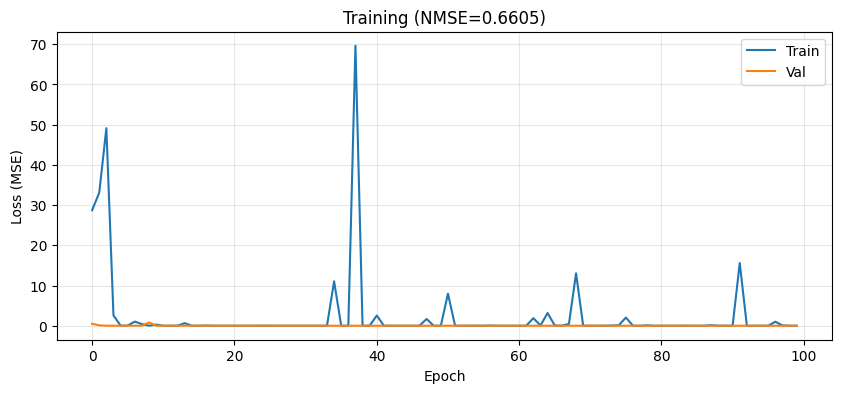


Final: NMSE = 0.660506


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title(f'Training (NMSE={nmse:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal: NMSE = {nmse:.6f}")